# Damped Harmonic Oscillator 

Damped harmonic oscillator takes form:

$y'' + 2\gamma y' + \omega_0^2 y = 0$ and has general solution:

$y(t) = A \exp{\left(\left( -\gamma + \sqrt{\gamma^2 -\omega_0^2}\right)t\right)} + B \exp{\left(\left( -\gamma - \sqrt{\gamma^2 -\omega_0^2}\right)t\right)}$

Require $\omega_0^2 > \gamma^2$ for underdamped oscilation. For this scenario, the general solution becomes

$y(t) = C e^{- \gamma t} \left(\exp{i (\sqrt{\omega_0^2 - \gamma^2}) t} + \exp{i (\sqrt{\omega_0^2 - \gamma^2}) t}\right)\\$
$\Rightarrow y(t) = 2C e^{-\gamma t} \cos{\left(\omega t + \phi\right)} \\$

where $\omega = \sqrt{\omega^2_0 -\gamma^2}$ and $\phi$ is some phase offset determined by the initial conditions. We will take $\phi = 0$ so the oscillator is at maximum displacement at $t=0$. 

Aim to make a neural network to approximate the harmonic oscillator function, initialised with random weights and biases.

In [2]:
import torch as t
import numpy as np 
import torch.nn as nn
import torch.optim as optim 
import torch.nn.functional as F #contains various functions including activation functions 
import matplotlib.pyplot as plt 

In [3]:
#Analytical Solution
#A = 2C here

def analytical(time, gamma, omega_0, A):
    omega = np.sqrt(omega_0**2 - gamma**2)
    envelope = A*np.exp(-gamma*time)
    return envelope*np.cos(omega*time), envelope

#System parameters
gamma = 2
omega_0 = 20
A = 1

t_analytical = np.linspace(0, 1, 500)
y_analytical = analytical(t_analytical, gamma, omega_0, A)
t_tensor = t.tensor(t_analytical, dtype= t.float32, requires_grad=True).view(-1,1)
t_initial = t.tensor(0., requires_grad=True).view(-1, 1) #t=0 tensor
# with t.no_grad():
#     print(t_initial, t_initial.shape)
#     print(t_analytical, t_analytical.shape)

In [4]:
class Model(nn.Module): #to call nn.Module to inherit pytorch nn functionality
    def __init__(self, in_channels, out_channels, hidden_channels, num_hidden_layers=2):
        #This function initialises the neural network, setting up the infrastructure to be used by forward
        #hidden_channels parameter is the number of neurons in each hidden layer
        super().__init__() #initialise nn.Module parent class first to use nn infrastructure
        self.input_layer = nn.Linear(in_channels, hidden_channels) #transforms input to match hidden
    
        self.hidden_layers = nn.ModuleList([nn.Linear(hidden_channels, hidden_channels) for _ in range(num_hidden_layers)]) 
        #creates {num_hidden_layers} hidden layers and adds a linear transformation 
        #with its own trainable weights and bias between each layer and ensures the inputs
        #and outputs of each hidden layer match the next.

        self.output_layer = nn.Linear(hidden_channels, out_channels) #transforms output of hidden layers
        #to the shape of the output channels

    def forward(self, x: t.tensor):
        #defines how data flows through the network 
        #x is a tensor with shape [batch_size, in_channels]
        x = F.tanh(self.input_layer(x)) #tanh activation function after first layer, introduces non-linearity
        #x leaves as tensor with shape [batch_size, hidden_channels]
        for hidden_layer in self.hidden_layers:
            x = F.sigmoid(hidden_layer(x)) #iterates through all hidden layers, applies linear transformation
            #and tanh activation
        #x leaves as tensor with shape [batch_size, output_channels]
        x = self.output_layer(x) #no activation function here
        return x 

Above code defines the neural network structure and the forward pass ie the neural network model. Key features are the requirement of inheriting the nn.Module class to make use of the pytorch neural network features off the bat- allows parameter tracking and easy gradient calculation. The number of hidden layers and neurons in each hidden layer can be tuned. Each layer applies a linear transformation to reshape its input into the correct shape to be passed on to the next layer, each transformation has its own weights and bias which can be trained. Use of super.__init__() allows layers to be looped through, indexed and their parameters can be accessed using list(model.parameters()). forward function adds tanh  activation functions after each linear transformation before being passed on to next layer.

Epoch: 1 / 25000. Total scaled loss: 3.1486e+01, 
                    y(0) loss: 2.0531e+00, 
                    y'(0) loss: 4.7173e-05, 
                    physics loss: 2.9433e+04


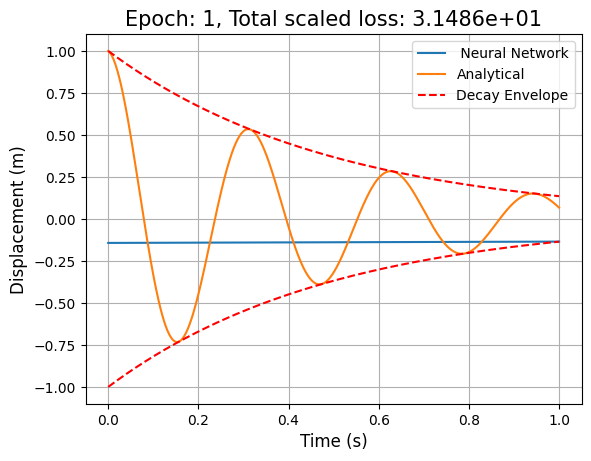

Epoch: 5000 / 25000. Total scaled loss: 3.4409e-03, 
                    y(0) loss: 4.7828e-05, 
                    y'(0) loss: 1.6419e-02, 
                    physics loss: 1.7512e+00


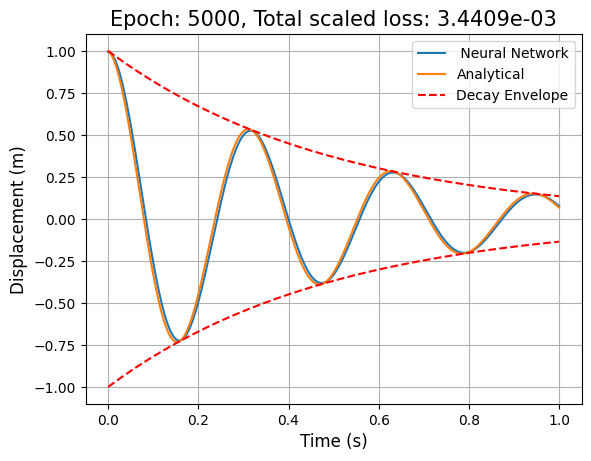

Epoch: 10000 / 25000. Total scaled loss: 8.7059e-04, 
                    y(0) loss: 1.2889e-05, 
                    y'(0) loss: 2.4655e-08, 
                    physics loss: 8.5770e-01


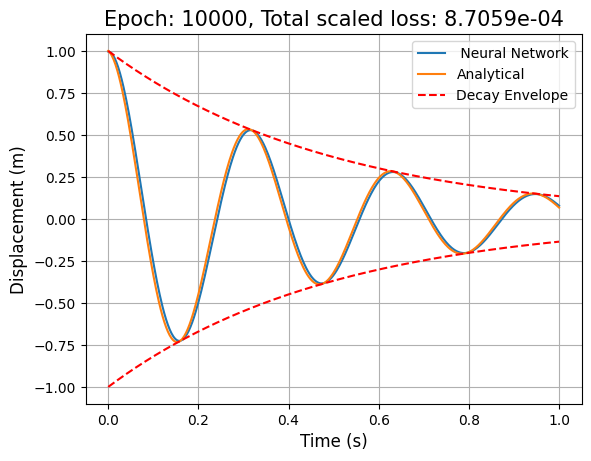

Epoch: 15000 / 25000. Total scaled loss: 1.3344e-03, 
                    y(0) loss: 3.5590e-05, 
                    y'(0) loss: 4.0579e-04, 
                    physics loss: 1.2582e+00


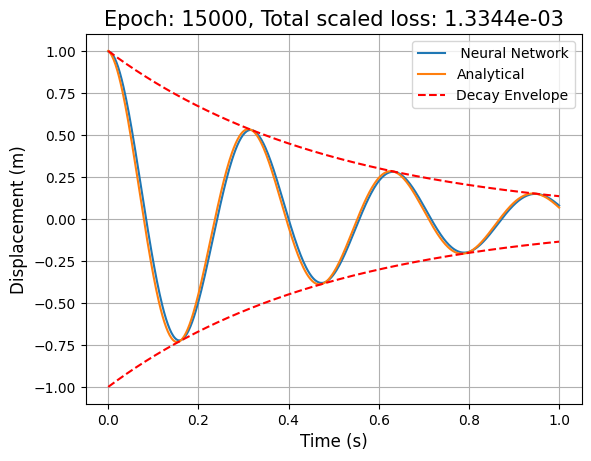

Epoch: 20000 / 25000. Total scaled loss: 5.8338e-04, 
                    y(0) loss: 5.4250e-06, 
                    y'(0) loss: 3.9503e-05, 
                    physics loss: 5.7401e-01


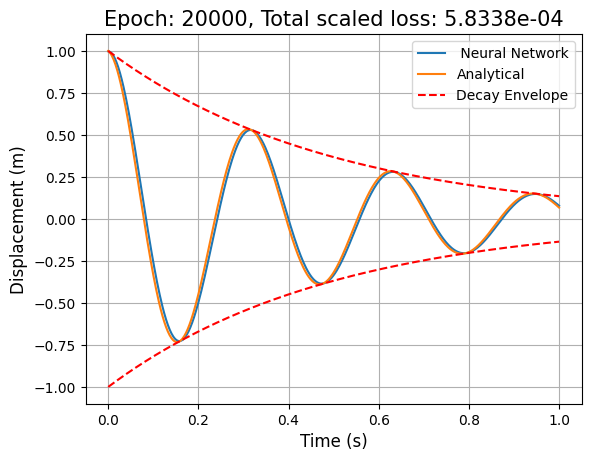

Epoch: 25000 / 25000. Total scaled loss: 7.9879e-04, 
                    y(0) loss: 2.9280e-06, 
                    y'(0) loss: 3.2665e-04, 
                    physics loss: 7.6320e-01


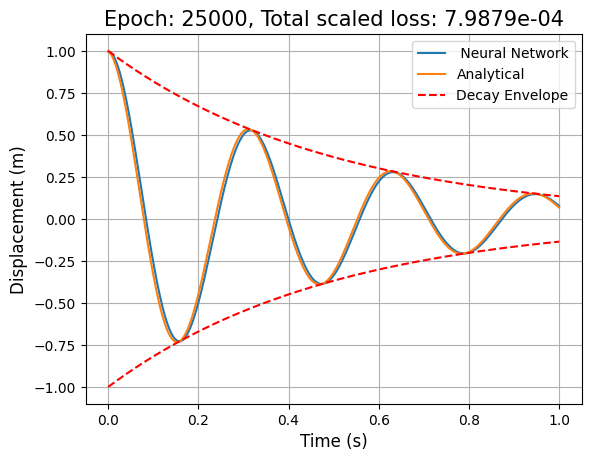

In [5]:
#Next step is loss and optimiser
learning_rate = 1e-2
model = Model(1, 1, 32)
# with t.no_grad():
#     for param in model.parameters():
#         print(param.shape, param[0]) #randomised weights and biases
optimiser = optim.Adam(model.parameters(), lr = learning_rate) #pass optimiser the trainable parameters

number_iterations = 25000
for epoch in range(number_iterations):
    y_predictedIC = model(t_initial)
    loss_y_IC = (t.squeeze(y_predictedIC) - A)**2 #start at maximum amplitude, squeeze returns input without 
    #specified dimensions of 1

    dy_predictedIC = t.autograd.grad(y_predictedIC, t_initial, t.ones_like(y_predictedIC), create_graph=True)[0]
    #above calculates the gradient of y_predicted wrt t_initial. t.ones_like gives vector of correct shape 
    #for vector jacobian product. ones_like gives direction of derivative and sums each derivative (1*y_1 + ... + 1*y_n). 
    #create_graph=True allows higher order derivatives to be created from this gradient object. 
    loss_dy_IC = (t.squeeze(dy_predictedIC) - 0)**2 #start with zero velocity

    y_predicted = model(t_tensor)
    dy_predicted = t.autograd.grad(y_predicted, t_tensor, t.ones_like(y_predicted), create_graph=True)[0]
    d2y_predicted = t.autograd.grad(dy_predicted, t_tensor, t.ones_like(dy_predicted), create_graph=True)[0]
    loss_y_sol = t.mean((d2y_predicted + 2*gamma*dy_predicted + omega_0**2*y_predicted)**2)

    loss = loss_y_sol*1e-3 + loss_y_IC + loss_dy_IC*1e-1 #start with equal scalings but if one is much smaller than
    #others then will effectively be ignored. Think about relative values of each loss and adjust accordingly.
    #Print losses at different steps to check.

    loss.backward()
    optimiser.step()
    optimiser.zero_grad()

    if (epoch + 1) % 5000 == 0 or epoch == 0:
        print(f"""Epoch: {epoch + 1} / {number_iterations}. Total scaled loss: {loss:.4e}, 
                    y(0) loss: {loss_y_IC:.4e}, 
                    y'(0) loss: {loss_dy_IC:.4e}, 
                    physics loss: {loss_y_sol:.4e}""")
        y_nn = model(t_tensor)
        plt.plot(t_tensor.detach().numpy(), y_nn.detach().numpy(), label = ' Neural Network')
        plt.plot(t_analytical, y_analytical[0], label = 'Analytical')
        plt.plot(t_analytical, y_analytical[1], linestyle = '--', color = 'red', label = 'Decay Envelope')
        plt.plot(t_analytical, -y_analytical[1], linestyle = '--', color = 'red')
        plt.title(f'Epoch: {epoch + 1}, Total scaled loss: {loss:.4e}', fontsize = 15)
        plt.xlabel('Time (s)', fontsize = 12)
        plt.ylabel('Displacement (m)', fontsize = 12)
        plt.grid()
        plt.legend()
        plt.show()

